Loading results from both methods...

Scanpy: 289380 total tests, 8114 significant
scVI: 2429 total tests

Merging results for comparison...
Merged dataset: 2429 gene-celltype pairs

Significant Gene Overlap - All Cell Types
Scanpy significant: 70
scVI significant: 1680
Overlap: 70 (4.2%)
Scanpy only: 0
scVI only: 1610

Significant Gene Overlap - CMS3
Scanpy significant: 12
scVI significant: 19
Overlap: 12 (63.2%)
Scanpy only: 0
scVI only: 7

Significant Gene Overlap - Tip-like ECs
Scanpy significant: 3
scVI significant: 29
Overlap: 3 (10.3%)
Scanpy only: 0
scVI only: 26

Significant Gene Overlap - B Cells
Scanpy significant: 0
scVI significant: 1
Overlap: 0 (0.0%)
Scanpy only: 0
scVI only: 1

Significant Gene Overlap - Spp1+
Scanpy significant: 7
scVI significant: 146
Overlap: 7 (4.8%)
Scanpy only: 0
scVI only: 139

Significant Gene Overlap - Mast cells
Scanpy significant: 3
scVI significant: 117
Overlap: 3 (2.6%)
Scanpy only: 0
scVI only: 114

Significant Gene Overlap - Stromal 2
Sca

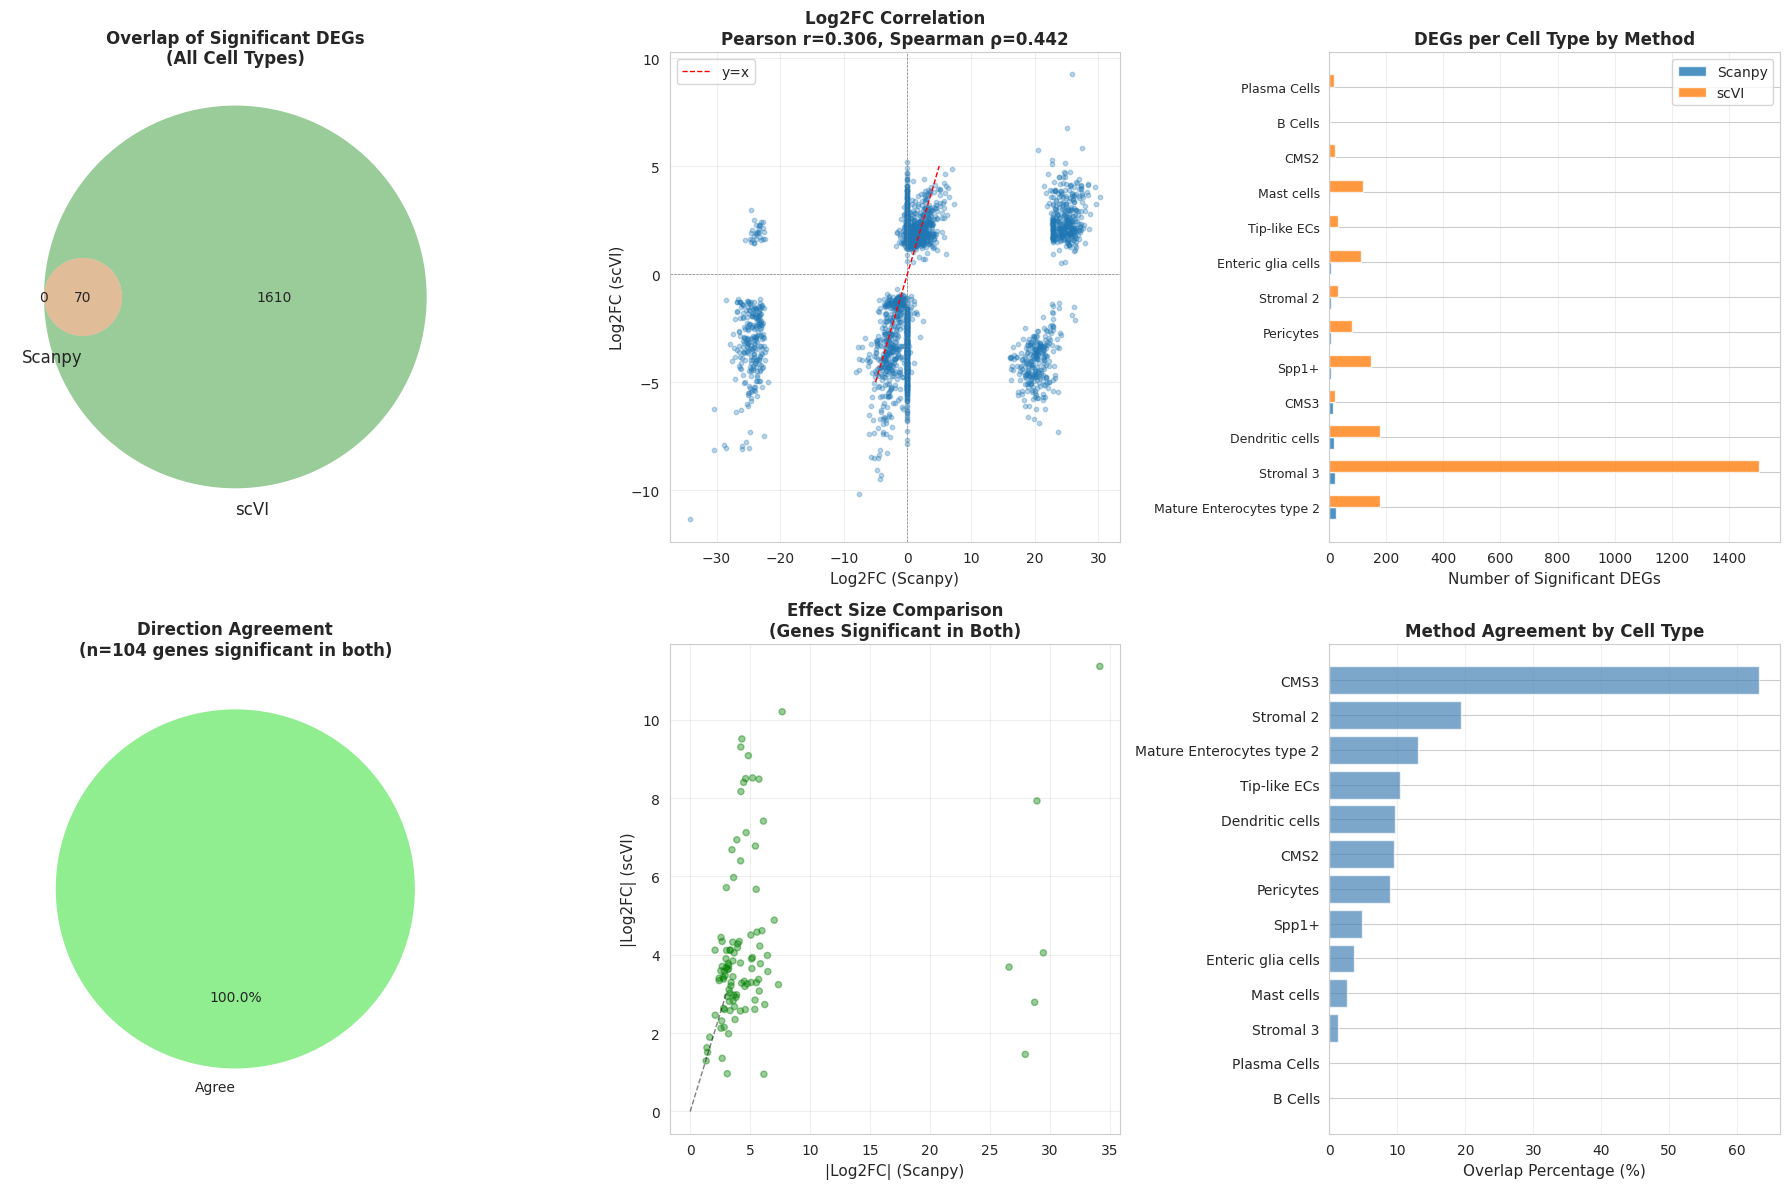


✅ Comparison figure saved: tumor_vs_normal_method_comparison.png

✅ Summary table saved: tumor_vs_normal_method_comparison_summary.csv

COMPARISON COMPLETE


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ============================================================================
# 1. LOAD RESULTS FROM BOTH METHODS
# ============================================================================

print("Loading results from both methods...")

# Load Scanpy results
scanpy_all = pd.read_csv('tumor_vs_normal_DEGs_all.csv')
scanpy_sig = pd.read_csv('tumor_vs_normal_DEGs_significant.csv')

# Load scVI results - need to load individual cell type files
scvi_results = {}
cell_types = scanpy_all['Cell_Type'].unique()

for cell_type in cell_types:
    filename = f"DEG_{cell_type.replace(' ', '_')}_tumor_vs_normal.csv"
    try:
        df = pd.read_csv(filename, index_col=0)
        df['Cell_Type'] = cell_type
        df['gene'] = df.index
        scvi_results[cell_type] = df
    except FileNotFoundError:
        print(f"Warning: {filename} not found")

# Combine all scVI results
scvi_all = pd.concat(scvi_results.values(), ignore_index=True)

print(f"\nScanpy: {len(scanpy_all)} total tests, {len(scanpy_sig)} significant")
print(f"scVI: {len(scvi_all)} total tests")

# ============================================================================
# 2. STANDARDIZE COLUMN NAMES FOR COMPARISON
# ============================================================================

# Rename columns to have consistent naming
scanpy_comparison = scanpy_all.rename(columns={
    'names': 'gene',
    'logfoldchanges': 'log2FC',
    'pvals_adj': 'padj'
}).copy()

scvi_comparison = scvi_all.rename(columns={
    'lfc_mean': 'log2FC',
    'proba_de': 'posterior_prob'
}).copy()

# Add method identifier
scanpy_comparison['method'] = 'Scanpy'
scvi_comparison['method'] = 'scVI'

# ============================================================================
# 3. MERGE RESULTS BY CELL TYPE AND GENE
# ============================================================================

print("\nMerging results for comparison...")

merged_results = pd.merge(
    scanpy_comparison[['gene', 'Cell_Type', 'log2FC', 'padj']],
    scvi_comparison[['gene', 'Cell_Type', 'log2FC', 'posterior_prob', 'is_de_fdr_0.05']],
    on=['gene', 'Cell_Type'],
    suffixes=('_scanpy', '_scvi'),
    how='inner'
)

print(f"Merged dataset: {len(merged_results)} gene-celltype pairs")

# ============================================================================
# 4. COMPARE SIGNIFICANT GENES BETWEEN METHODS
# ============================================================================

def compare_significant_genes(merged_df, cell_type=None):
    """Compare overlap of significant genes between methods"""
    
    if cell_type:
        df = merged_df[merged_df['Cell_Type'] == cell_type].copy()
        title_suffix = f" - {cell_type}"
    else:
        df = merged_df.copy()
        title_suffix = " - All Cell Types"
    
    # Define significant genes for each method
    scanpy_sig_genes = set(df[df['padj'] < 0.05]['gene'])
    
    # For strict filtering: use the is_de_fdr_0.05 column
    scvi_sig_genes = set(df[df['is_de_fdr_0.05'] == True]['gene'])
    
    # Calculate overlap
    overlap = scanpy_sig_genes & scvi_sig_genes
    scanpy_only = scanpy_sig_genes - scvi_sig_genes
    scvi_only = scvi_sig_genes - scanpy_sig_genes
    
    print(f"\n{'='*60}")
    print(f"Significant Gene Overlap{title_suffix}")
    print(f"{'='*60}")
    print(f"Scanpy significant: {len(scanpy_sig_genes)}")
    print(f"scVI significant: {len(scvi_sig_genes)}")
    
    # Handle division by zero
    max_sig = max(len(scanpy_sig_genes), len(scvi_sig_genes))
    if max_sig > 0:
        overlap_pct = len(overlap) / max_sig * 100
        print(f"Overlap: {len(overlap)} ({overlap_pct:.1f}%)")
    else:
        print(f"Overlap: {len(overlap)} (N/A - no significant genes)")
    
    print(f"Scanpy only: {len(scanpy_only)}")
    print(f"scVI only: {len(scvi_only)}")
    
    return {
        'scanpy_sig': scanpy_sig_genes,
        'scvi_sig': scvi_sig_genes,
        'overlap': overlap,
        'scanpy_only': scanpy_only,
        'scvi_only': scvi_only
    }

# Overall comparison
overall_comparison = compare_significant_genes(merged_results)

# Per cell type comparison
celltype_comparisons = {}
for ct in merged_results['Cell_Type'].unique():
    celltype_comparisons[ct] = compare_significant_genes(merged_results, ct)

# ============================================================================
# 5. CORRELATION ANALYSIS OF LOG2FC VALUES
# ============================================================================

print("\n" + "="*60)
print("Log2FC Correlation Analysis")
print("="*60)

# Remove infinite or NaN values
merged_clean = merged_results[
    np.isfinite(merged_results['log2FC_scanpy']) & 
    np.isfinite(merged_results['log2FC_scvi'])
].copy()

# Calculate correlations
pearson_r, pearson_p = pearsonr(merged_clean['log2FC_scanpy'], 
                                  merged_clean['log2FC_scvi'])
spearman_r, spearman_p = spearmanr(merged_clean['log2FC_scanpy'], 
                                     merged_clean['log2FC_scvi'])

print(f"Pearson correlation: {pearson_r:.3f} (p={pearson_p:.2e})")
print(f"Spearman correlation: {spearman_r:.3f} (p={spearman_p:.2e})")

# ============================================================================
# 6. VISUALIZATION
# ============================================================================

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# --- Plot 1: Venn Diagram of Overall Overlap ---
ax1 = plt.subplot(2, 3, 1)
venn2([overall_comparison['scanpy_sig'], overall_comparison['scvi_sig']], 
      set_labels=('Scanpy', 'scVI'),
      ax=ax1)
ax1.set_title('Overlap of Significant DEGs\n(All Cell Types)', fontsize=12, fontweight='bold')

# --- Plot 2: Log2FC Correlation Scatter Plot ---
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(merged_clean['log2FC_scanpy'], 
           merged_clean['log2FC_scvi'],
           alpha=0.3, s=10)
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax2.plot([-5, 5], [-5, 5], 'r--', linewidth=1, label='y=x')
ax2.set_xlabel('Log2FC (Scanpy)', fontsize=11)
ax2.set_ylabel('Log2FC (scVI)', fontsize=11)
ax2.set_title(f'Log2FC Correlation\nPearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f}', 
             fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Plot 3: Number of DEGs per Cell Type ---
ax3 = plt.subplot(2, 3, 3)
deg_counts = []
for ct in merged_results['Cell_Type'].unique():
    scanpy_n = len(celltype_comparisons[ct]['scanpy_sig'])
    scvi_n = len(celltype_comparisons[ct]['scvi_sig'])
    overlap_n = len(celltype_comparisons[ct]['overlap'])
    deg_counts.append({
        'Cell_Type': ct,
        'Scanpy': scanpy_n,
        'scVI': scvi_n,
        'Overlap': overlap_n
    })

deg_counts_df = pd.DataFrame(deg_counts).sort_values('Overlap', ascending=False)

x = np.arange(len(deg_counts_df))
width = 0.35

ax3.barh(x - width/2, deg_counts_df['Scanpy'], width, label='Scanpy', alpha=0.8)
ax3.barh(x + width/2, deg_counts_df['scVI'], width, label='scVI', alpha=0.8)
ax3.set_yticks(x)
ax3.set_yticklabels(deg_counts_df['Cell_Type'], fontsize=9)
ax3.set_xlabel('Number of Significant DEGs', fontsize=11)
ax3.set_title('DEGs per Cell Type by Method', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='x')

# --- Plot 4: Agreement Direction (Up/Down regulated) ---
ax4 = plt.subplot(2, 3, 4)

# Only look at genes significant in BOTH methods
both_sig = merged_results[
    (merged_results['padj'] < 0.05)
    # scVI genes are already all significant from the filtered files
].copy()

# Classify direction agreement
both_sig['scanpy_dir'] = np.sign(both_sig['log2FC_scanpy'])
both_sig['scvi_dir'] = np.sign(both_sig['log2FC_scvi'])
both_sig['agreement'] = both_sig['scanpy_dir'] == both_sig['scvi_dir']

if len(both_sig) > 0:
    agreement_counts = both_sig['agreement'].value_counts()
    
    # Ensure we have labels that match the data
    labels = []
    values = []
    colors = []
    
    if True in agreement_counts.index:
        labels.append('Agree')
        values.append(agreement_counts[True])
        colors.append('lightgreen')
    
    if False in agreement_counts.index:
        labels.append('Disagree')
        values.append(agreement_counts[False])
        colors.append('salmon')
    
    ax4.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax4.set_title(f'Direction Agreement\n(n={len(both_sig)} genes significant in both)', 
                 fontsize=12, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No overlapping\nsignificant genes', 
             ha='center', va='center', fontsize=12)
    ax4.set_title('Direction Agreement\n(n=0 genes)', 
                 fontsize=12, fontweight='bold')
    ax4.axis('off')

# --- Plot 5: Effect Size Comparison (only significant genes) ---
ax5 = plt.subplot(2, 3, 5)

both_sig_clean = both_sig[
    np.isfinite(both_sig['log2FC_scanpy']) & 
    np.isfinite(both_sig['log2FC_scvi'])
].copy()

ax5.scatter(np.abs(both_sig_clean['log2FC_scanpy']), 
           np.abs(both_sig_clean['log2FC_scvi']),
           alpha=0.4, s=20, c=both_sig_clean['agreement'].map({True: 'green', False: 'red'}))
ax5.plot([0, 3], [0, 3], 'k--', linewidth=1, alpha=0.5)
ax5.set_xlabel('|Log2FC| (Scanpy)', fontsize=11)
ax5.set_ylabel('|Log2FC| (scVI)', fontsize=11)
ax5.set_title('Effect Size Comparison\n(Genes Significant in Both)', 
             fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# --- Plot 6: Overlap percentage by cell type ---
ax6 = plt.subplot(2, 3, 6)

overlap_pcts = []
for ct in merged_results['Cell_Type'].unique():
    comp = celltype_comparisons[ct]
    total = len(comp['scanpy_sig'] | comp['scvi_sig'])
    overlap_pct = len(comp['overlap']) / total * 100 if total > 0 else 0
    overlap_pcts.append({'Cell_Type': ct, 'Overlap_%': overlap_pct})

overlap_df = pd.DataFrame(overlap_pcts).sort_values('Overlap_%', ascending=True)

ax6.barh(overlap_df['Cell_Type'], overlap_df['Overlap_%'], color='steelblue', alpha=0.7)
ax6.set_xlabel('Overlap Percentage (%)', fontsize=11)
ax6.set_title('Method Agreement by Cell Type', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('tumor_vs_normal_method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison figure saved: tumor_vs_normal_method_comparison.png")

# ============================================================================
# 7. SAVE COMPARISON SUMMARY
# ============================================================================


# Create summary table
summary_rows = []
for ct in merged_results['Cell_Type'].unique():
    comp = celltype_comparisons[ct]
    
    # Handle division by zero for overlap percentage
    max_sig = max(len(comp['scanpy_sig']), len(comp['scvi_sig']))
    overlap_pct = (len(comp['overlap']) / max_sig * 100) if max_sig > 0 else 0
    
    summary_rows.append({
        'Cell_Type': ct,
        'Scanpy_DEGs': len(comp['scanpy_sig']),
        'scVI_DEGs': len(comp['scvi_sig']),
        'Overlap': len(comp['overlap']),
        'Scanpy_only': len(comp['scanpy_only']),
        'scVI_only': len(comp['scvi_only']),
        'Overlap_pct': overlap_pct
    })

summary_table = pd.DataFrame(summary_rows).sort_values('Overlap', ascending=False)
summary_table.to_csv('tumor_vs_normal_method_comparison_summary.csv', index=False)

print("\n✅ Summary table saved: tumor_vs_normal_method_comparison_summary.csv")
print("\n" + "="*60)
print("COMPARISON COMPLETE")
print("="*60)

In [2]:
# 1. Check direction agreement for overlapping significant genes
overlap_genes = overall_comparison['overlap']
overlap_df = merged_results[merged_results['gene'].isin(overlap_genes)].copy()

overlap_df['same_direction'] = (
    (overlap_df['log2FC_scanpy'] > 0) == (overlap_df['log2FC_scvi'] > 0)
)

direction_agreement = overlap_df['same_direction'].sum() / len(overlap_df) * 100
print(f"\nDirection agreement for overlapping genes: {direction_agreement:.1f}%")

# 2. Check how many genes are significant in at least one method
total_sig_either = len(overall_comparison['scanpy_sig'] | overall_comparison['scvi_sig'])
overlap_sig = len(overall_comparison['overlap'])
print(f"\nGenes significant in at least one method: {total_sig_either}")
print(f"Genes significant in both methods: {overlap_sig} ({overlap_sig/total_sig_either*100:.1f}%)")

# 3. Compare top genes from each method
print("\n" + "="*60)
print("TOP 20 UPREGULATED GENES")
print("="*60)

scanpy_top_up = merged_results.nlargest(20, 'log2FC_scanpy')[['gene', 'Cell_Type', 'log2FC_scanpy', 'padj']]
scvi_top_up = merged_results.nlargest(20, 'log2FC_scvi')[['gene', 'Cell_Type', 'log2FC_scvi', 'is_de_fdr_0.05']]

print("\nScanpy top 20:")
print(scanpy_top_up)

print("\nscVI top 20:")
print(scvi_top_up)

# Check overlap in top genes
top_overlap = set(scanpy_top_up['gene']) & set(scvi_top_up['gene'])
print(f"\nOverlap in top 20 upregulated genes: {len(top_overlap)}/20")


Direction agreement for overlapping genes: 94.1%

Genes significant in at least one method: 1650
Genes significant in both methods: 115 (7.0%)

TOP 20 UPREGULATED GENES

Scanpy top 20:
          gene        Cell_Type  log2FC_scanpy      padj
4261     IGHG4     Plasma Cells      29.463263  0.019371
698       SPP1            Spp1+      29.414244  1.000000
5142    SLC5A3        Stromal 3      28.578375  1.000000
1620     TGFBI             CMS2      28.551560  0.118791
716      CXCL1            Spp1+      28.451588  1.000000
711      NUPR1            Spp1+      28.092735  1.000000
4260     PSMA2     Plasma Cells      28.011642  0.007308
2205     EVA1B        Pericytes      27.956596  0.350522
5041      BNC2        Stromal 3      27.902328  0.327714
751      IFI27            Spp1+      27.802778  1.000000
767      CXCL9            Spp1+      27.698614  1.000000
5068     IGLC2        Stromal 3      27.671856  0.863084
701      IGLC3            Spp1+      27.628836  1.000000
2277    HILPDA  

In [3]:
# For each cell type, identify consensus DEGs
consensus_degs = {}

for cell_type in merged_results['Cell_Type'].unique():
    ct_data = merged_results[merged_results['Cell_Type'] == cell_type]
    
    # Genes significant in BOTH methods
    consensus = ct_data[
        (ct_data['padj'] < 0.05) & 
        (ct_data['is_de_fdr_0.05'] == True)
    ]
    
    # And agree on direction
    consensus = consensus[
        np.sign(consensus['log2FC_scanpy']) == np.sign(consensus['log2FC_scvi'])
    ]
    
    consensus_degs[cell_type] = consensus
    
    print(f"{cell_type}: {len(consensus)} consensus DEGs")

# Use these for downstream analysis

CD4+ T Cells: 0 consensus DEGs
CMS3: 0 consensus DEGs
Tip-like ECs: 1 consensus DEGs
CD8+ T cells: 0 consensus DEGs
B Cells: 0 consensus DEGs
Spp1+: 0 consensus DEGs
Mast cells: 0 consensus DEGs
Stromal 2: 1 consensus DEGs
CMS2: 0 consensus DEGs
Regulatory T Cells: 0 consensus DEGs
Pericytes: 3 consensus DEGs
Dendritic cells: 0 consensus DEGs
Gamma delta T cells: 0 consensus DEGs
Helper 17 T cells: 0 consensus DEGs
Mature Enterocytes type 2: 2 consensus DEGs
NK cells: 0 consensus DEGs
Plasma Cells: 0 consensus DEGs
Stromal 3: 19 consensus DEGs
Follicular helper T cells: 0 consensus DEGs
Enteric glia cells: 2 consensus DEGs


In [4]:
# Analyze why some cell types have fewer DEGs
for cell_type in merged_results['Cell_Type'].unique():
    ct_data = merged_results[merged_results['Cell_Type'] == cell_type]
    
    print(f"\n{cell_type}:")
    print(f"  Total genes tested: {len(ct_data)}")
    print(f"  Scanpy significant: {(ct_data['padj'] < 0.05).sum()}")
    print(f"  scVI significant: {(ct_data['is_de_fdr_0.05']).sum()}")
    print(f"  Mean |log2FC| (Scanpy): {ct_data['log2FC_scanpy'].abs().mean():.2f}")
    print(f"  Mean |log2FC| (scVI): {ct_data['log2FC_scvi'].abs().mean():.2f}")


CD4+ T Cells:
  Total genes tested: 113
  Scanpy significant: 46
  scVI significant: 0
  Mean |log2FC| (Scanpy): 2.58
  Mean |log2FC| (scVI): 2.17

CMS3:
  Total genes tested: 257
  Scanpy significant: 99
  scVI significant: 0
  Mean |log2FC| (Scanpy): 5.79
  Mean |log2FC| (scVI): 2.67

Tip-like ECs:
  Total genes tested: 4
  Scanpy significant: 1
  scVI significant: 4
  Mean |log2FC| (Scanpy): 12.45
  Mean |log2FC| (scVI): 4.36

CD8+ T cells:
  Total genes tested: 26
  Scanpy significant: 8
  scVI significant: 0
  Mean |log2FC| (Scanpy): 4.55
  Mean |log2FC| (scVI): 2.35

B Cells:
  Total genes tested: 264
  Scanpy significant: 91
  scVI significant: 0
  Mean |log2FC| (Scanpy): 2.81
  Mean |log2FC| (scVI): 2.39

Spp1+:
  Total genes tested: 946
  Scanpy significant: 21
  scVI significant: 0
  Mean |log2FC| (Scanpy): 10.97
  Mean |log2FC| (scVI): 2.62

Mast cells:
  Total genes tested: 3
  Scanpy significant: 0
  scVI significant: 3
  Mean |log2FC| (Scanpy): 22.44
  Mean |log2FC| (scV